# Time series analysis with ARIMA
Some time ago I had a discussion about time series analysis and ARIMA models, which found me quite unprepared!
So I decided to look a bit closer to this neat piece of classical time series analysis. I found out that there are several excellent tutorials on how to use ARIMA, which I link below. Still, I found it useful to compile my own example to summarize my understanding of the problem and to collect links to useful resources.

## Import libraries and get sample data

In [4]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [6]:
# 导入训练数据
data = pd.read_csv('data1.csv')
data.head()

,platform_open_id,goods_num,price,is_member,discount_fee,outer_id,take_at,status,payment,member_id,order_payment,total_fee,goods_id
0,101ZX1xyfG/omvnxQPYI8YPFhoi2hfl26RoAPgzb9VqwG0=,1,3650.0,0,300.0,302945-01,2020-01-01 01:35:43,6,3350.0,0,3350.0,3350.0,520399672992
1,爱012Pr5yntLUcTKU0MtsjPGOs2DEMds1FAQI7fgfrP3PMg=,1,2690.0,0,600.0,227605-01,2020-01-01 08:55:17,6,2090.0,0,2090.0,2090.0,548452717637
2,朱01i4Rmip4x6V5VS/UZPBzc+Nnn6lnZ7cacExIx+8aylCY=,1,3990.0,1,400.0,226403-01,2020-01-01 09:48:35,6,3590.0,616297,3590.0,3590.0,564779472639
3,001bRbDk61o6cYW1XuaH8XgLgKHM0CMIQafAKaTQc17qGM=,1,3290.0,0,0.0,NaN,2020-01-01 09:56:04,6,3290.0,0,3290.0,3290.0,609664493135
4,t014Au7WHWPPI0OeT5DX13SQ5q8qGekDqre2uZnHtcQpY8=,1,3590.0,1,500.0,282846-01,2020-01-01 10:36:50,6,3090.0,220404,3090.0,3090.0,589083659427


In [7]:
# 提取时间戳“take_at”有用信息 这里的'int_date'用于根据购买时间进行排序，因为上面可以看出时间顺序有错误
date1 = data['take_at'].str.split(' ').str[0]
date2 = data['take_at'].str.split(' ').str[1]
data['year-month-day']=date1
time_1 = date1.str.split('-').str[0]+date1.str.split('-').str[1]
print(time_1)
data['int_date'] = time_1

0          202001
1          202001
2          202001
3          202001
4          202001
            ...  
2076751    202106
2076752    202106
2076753    202106
2076754    202106
2076755    202106
Name: take_at, Length: 2076756, dtype: object


In [8]:
# 得到最后的要统计的数据
# 得到最后的要统计的数据（取需要的列，将int_date转换成int类型，便于根据时间排序，也可以作为特征）
data_last = data[['year-month-day','status','int_date','goods_id','price','discount_fee','payment']]

# 关闭 SettingWithCopy警告，解决可以通过（.copy()）
pd.set_option('mode.chained_assignment', None)
data_last["int_date"] = pd.to_numeric(data_last["int_date"])
data_last.sort_values("int_date",inplace=True)

# 只取状态6，也就是交易成功，不考虑退款情况的
data_last=data_last[data_last['status']==6]
data_last = data_last.drop(data_last[(data_last['payment']<10)].index)
data_last = data_last[['int_date','year-month-day','payment']]
data_last.head()

,int_date,year-month-day,payment
0,202001,2020-01-01,3350.0
1208762,202001,2020-01-09,2090.0
1208758,202001,2020-01-09,3590.0
1208757,202001,2020-01-09,1550.0
1208756,202001,2020-01-09,3290.0


In [9]:
data_day = data_last.groupby('year-month-day')
# 每一天的GMV数据(status=6)
day_ = list(data_day)
gmv_day= []
for i in range(len(list(data_day))):
    gmv_1=day_[i][1]['payment'].sum()
    gmv_day.append(gmv_1)
gmv_day

[8117806.0,
 2465348.0,
 2298608.0,
 2071824.0,
 1269618.0,
 25925036.0,
 8077788.0,
 7446776.0,
 8343364.0,
 7927048.0,
 3116266.0,
 3223466.0,
 3253080.0,
 2525816.0,
 13044796.0,
 5895848.0,
 4473678.0,
 3856678.0,
 3862996.0,
 3048520.0,
 2756670.0,
 2351418.0,
 2681438.0,
 2677160.0,
 3060880.0,
 3401030.0,
 4584176.0,
 4317098.0,
 5169278.0,
 6052270.0,
 2134600.0,
 2531606.0,
 2254110.0,
 1930700.0,
 1951782.0,
 1674616.0,
 2351170.0,
 1302224.0,
 11797250.0,
 6550372.0,
 7453448.0,
 5799996.0,
 7708266.0,
 7175370.0,
 9701312.0,
 2738680.0,
 3050736.0,
 6949658.0,
 10934650.0,
 6796726.0,
 6812140.0,
 6717760.0,
 6012430.0,
 3049128.0,
 2939154.0,
 2201574.0,
 1776858.0,
 1644456.0,
 9282638.0,
 5007416.0,
 5449684.0,
 1778064.0,
 1389410.0,
 763664.0,
 26300587.0,
 12358904.0,
 10764140.0,
 14764669.0,
 4618097.0,
 1319156.0,
 1263796.0,
 1196941.0,
 6528061.0,
 3746303.0,
 4819891.0,
 1845003.0,
 1782549.0,
 1874990.0,
 1767444.0,
 1584126.0,
 1708300.0,
 6599504.0,
 3443128.

In [10]:
data_month = data_last.groupby('int_date')
# 每一天的GMV数据(status=6)
month_ = list(data_month)
gmv_month= []
for i in range(len(list(data_month))):
    gmv_2=month_[i][1]['payment'].sum()
    gmv_month.append(gmv_2)
gmv_month

[159430378.0,
 146096226.0,
 133563449.0,
 100220126.0,
 151425165.0,
 317112566.2,
 67729954.0,
 95115627.48,
 80514360.0,
 335847154.0,
 463410755.73,
 161958049.0,
 155719511.0,
 120081634.0,
 165153090.0,
 133661051.87999998,
 167460867.0,
 260667715.54]

In [11]:
data_to_use = pd.DataFrame({'Month':[],'y':[]})
# 生成时间列表
start_date = "20200101"
date_list = pd.date_range(start=start_date, periods=547).strftime("%Y-%m-%d").tolist()
data_to_use['Month'] = date_list
data_to_use['y'] = gmv_day
data_to_use

,Month,y
0,2020-01-01,8117806.00
1,2020-01-02,2465348.00
2,2020-01-03,2298608.00
3,2020-01-04,2071824.00
4,2020-01-05,1269618.00
...,...,...
542,2021-06-26,996315.72
543,2021-06-27,513678.00
544,2021-06-28,469200.00
545,2021-06-29,440030.00


In [12]:
# A bit of pre-processing to make it nicer
data_to_use['Month']=pd.to_datetime(data_to_use['Month'], format='%Y-%m-%d')
data_to_use.set_index(['Month'], inplace=True)
data_to_use.head()

,y
Month,
2020-01-01,8117806.0
2020-01-02,2465348.0
2020-01-03,2298608.0
2020-01-04,2071824.0
2020-01-05,1269618.0


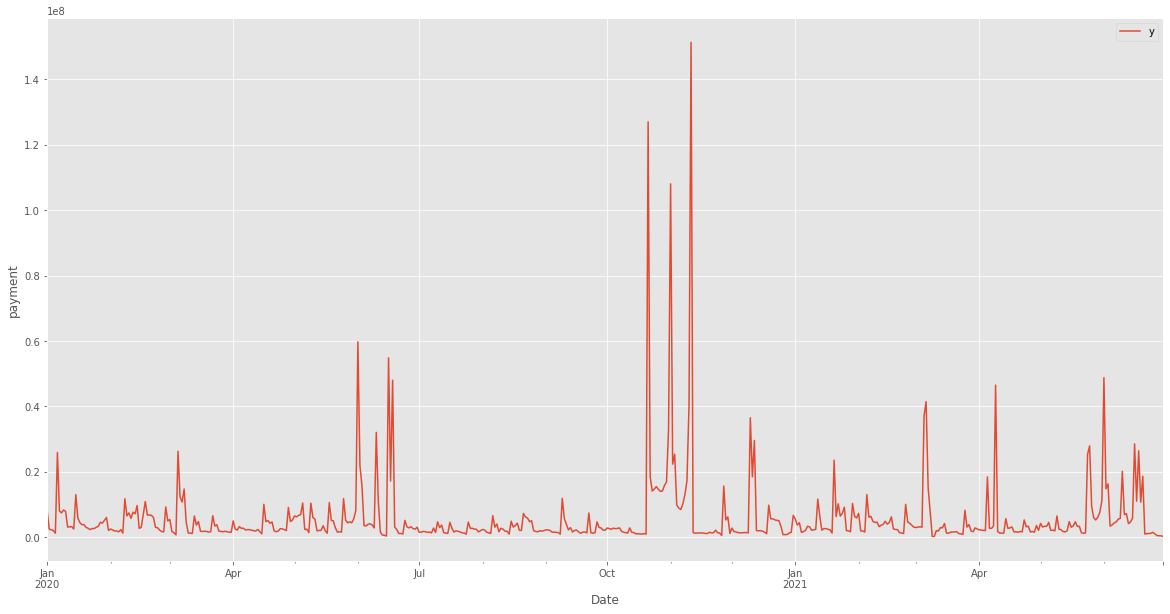

In [13]:
# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')
data_to_use.plot()
# Plot the data
plt.ylabel('payment')
plt.xlabel('Date')
plt.show()

数据中出现了两种明显的模式，一种是随着时间的推移，乘客数量总体增加，另一种是12个月的季节性，高峰对应北半球夏季。

###
ARIMA代表自回归综合移动平均。有三个整数（p，d，q）用于参数化ARIMA模型。因此，非季节ARIMA模型用ARIMA（p，d，q）表示：

p是自回归项的个数（AR部分）。它允许将过去值的影响合并到我们的模型中。凭直觉，这类似于说，如果过去3天天气暖和，明天可能会暖和。

d是平稳性所需的非季节性差异数。凭直觉，这类似于说，如果最近三天的温差很小，明天的气温很可能是相同的。

q是预测方程（MA部分）中滞后预测误差的数量。这允许我们将模型的误差设置为过去在以前时间点观察到的误差值的线性组合。

在处理季节性影响时，如我们的示例中所示，使用季节性ARIMA，表示为ARIMA（p，d，q）（p，d，q）s。这里，（p，d，q）是上述非季节性参数，（p，d，q）遵循相同的定义，但适用于时间序列的季节性成分。术语s是时间序列的周期性。

在这种情况下，很明显s=12，我们如何设置其他参数？

这在很大程度上是基于经验。可以遵循许多最佳实践来确定ARIMA模型，例如：http://people.duke.edu/~rnau/arimrule.htm。

在这里，我们在预定义的值范围内使用网格搜索所有可能的参数值组合（深受https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3).

𝑠𝑡𝑎𝑡𝑠𝑚𝑜𝑑𝑒𝑙𝑠.𝑡𝑠𝑎.𝑠𝑡𝑎𝑡𝑒𝑠𝑝𝑎𝑐𝑒.𝑠𝑎𝑟𝑖𝑚𝑎𝑥.𝑆𝐴𝑅𝐼𝑀𝐴𝑋𝑅𝑒𝑠𝑢𝑙𝑡𝑠statsmodels.tsa.statespace.sarimax.SARIMAXResults返回AIC（Akaike信息准则）和BIC（Bayes信息准则）的值，可以最小化这些值以选择最佳拟合模型。我们使用AIC值，当给定的模型用于表示生成数据的过程时，AIC值估计信息丢失。在此过程中，它处理模型的拟合优度和模型本身的复杂性之间的权衡。

In [14]:
# 将d和q参数定义为0到1之间的任意值
q = d = range(0, 2)
# 将p参数定义为0到3之间的任意值
p = range(0, 4)

# 生成p, q, q三联体的所有不同组合
pdq = list(itertools.product(p, d, q))
print(pdq)
# 生成所有季节的不同组合p、q和问三胞胎
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]
print(seasonal_pdq)
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 0, 1), (2, 1, 0), (2, 1, 1), (3, 0, 0), (3, 0, 1), (3, 1, 0), (3, 1, 1)]
[(0, 0, 0, 7), (0, 0, 1, 7), (0, 1, 0, 7), (0, 1, 1, 7), (1, 0, 0, 7), (1, 0, 1, 7), (1, 1, 0, 7), (1, 1, 1, 7), (2, 0, 0, 7), (2, 0, 1, 7), (2, 1, 0, 7), (2, 1, 1, 7), (3, 0, 0, 7), (3, 0, 1, 7), (3, 1, 0, 7), (3, 1, 1, 7)]
Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 1, 0) x (0, 1, 1, 7)
SARIMAX: (0, 1, 0) x (1, 0, 0, 7)


我们选择数据序列的一个子集作为训练数据，比如前11年。我们的目标是基于此输入预测该系列的最后一年

In [15]:
train_data =data_to_use['2020-01-01':'2021-01-01']
test_data = data_to_use['2021-01-01':'2021-07-01']

In [17]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 7) - AIC:13117.513529358044
SARIMAX(0, 0, 0)x(0, 0, 1, 7) - AIC:12855.151984917022
SARIMAX(0, 0, 0)x(0, 1, 0, 7) - AIC:13022.807323268124
SARIMAX(0, 0, 0)x(0, 1, 1, 7) - AIC:12583.424647731435
SARIMAX(0, 0, 0)x(1, 0, 0, 7) - AIC:12885.833028910052
SARIMAX(0, 0, 0)x(1, 0, 1, 7) - AIC:12815.796746362106
SARIMAX(0, 0, 0)x(1, 1, 0, 7) - AIC:12727.006646842543
SARIMAX(0, 0, 0)x(1, 1, 1, 7) - AIC:12583.775085368241
SARIMAX(0, 0, 0)x(2, 0, 0, 7) - AIC:12637.461734353228
SARIMAX(0, 0, 0)x(2, 0, 1, 7) - AIC:12607.333605168114
SARIMAX(0, 0, 0)x(2, 1, 0, 7) - AIC:12398.92664649997
SARIMAX(0, 0, 0)x(2, 1, 1, 7) - AIC:12369.951933526118
SARIMAX(0, 0, 0)x(3, 0, 0, 7) - AIC:12361.08104908152
SARIMAX(0, 0, 0)x(3, 0, 1, 7) - AIC:12362.824579545206
SARIMAX(0, 0, 0)x(3, 1, 0, 7) - AIC:12154.289625096175
SARIMAX(0, 0, 0)x(3, 1, 1, 7) - AIC:12112.123080048954
SARIMAX(0, 0, 1)x(0, 0, 0, 7) - AIC:13044.26474272793
SARIMAX(0, 0, 1)x(0, 0, 1, 7) - AIC:12791.415474277172
SARIMAX(0, 0,

SARIMAX(2, 0, 1)x(1, 1, 0, 7) - AIC:13091.849190828249
SARIMAX(2, 0, 1)x(1, 1, 1, 7) - AIC:13026.003319216517
SARIMAX(2, 0, 1)x(2, 0, 0, 7) - AIC:12506.36798008155
SARIMAX(2, 0, 1)x(2, 0, 1, 7) - AIC:12511.858502494097
SARIMAX(2, 0, 1)x(2, 1, 0, 7) - AIC:12698.855029341546
SARIMAX(2, 0, 1)x(2, 1, 1, 7) - AIC:12314.273596406509
SARIMAX(2, 0, 1)x(3, 0, 0, 7) - AIC:12243.99886860687
SARIMAX(2, 0, 1)x(3, 0, 1, 7) - AIC:12245.18165219193
SARIMAX(2, 0, 1)x(3, 1, 0, 7) - AIC:12344.23272925037
SARIMAX(2, 0, 1)x(3, 1, 1, 7) - AIC:12341.33594106115
SARIMAX(2, 1, 0)x(0, 0, 0, 7) - AIC:13030.043928160354
SARIMAX(2, 1, 0)x(0, 0, 1, 7) - AIC:12819.155766281026
SARIMAX(2, 1, 0)x(0, 1, 0, 7) - AIC:13048.335893110536
SARIMAX(2, 1, 0)x(0, 1, 1, 7) - AIC:12649.245823666486
SARIMAX(2, 1, 0)x(1, 0, 0, 7) - AIC:12784.49171932786
SARIMAX(2, 1, 0)x(1, 0, 1, 7) - AIC:12786.32117481413
SARIMAX(2, 1, 0)x(1, 1, 0, 7) - AIC:12714.03503949344
SARIMAX(2, 1, 0)x(1, 1, 1, 7) - AIC:12615.187917258678
SARIMAX(2, 1, 0)x(

In [18]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 12025.267694307227 for model SARIMAX(3, 0, 1)x(3, 1, 1, 7)


In [19]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

一旦模型被拟合，我们就可以检查它是否符合我们的预期，是否违背了我们的假设。为此，我们可以使用$plot\ diagnostics$方法。

In [ ]:
results.plot_diagnostics()
plt.show()

在上述地块中，我们可以观察到残差是不相关的（右下图），没有明显的季节性（左上角）。此外，残差和大致正态分布，平均值为零（右上图）。左下角qq图显示，剩余（蓝点）的有序分布服从N（0，1）标准正态分布样本的线性趋势。同样，这是一个很强的迹象，表明残余物是正态分布的。

## Results
现在让我们来做一些预测。我们将使用三种方法：

上一年（1959年）一步预报的样本预测。在这种情况下，模型用于预测建立模型所依据的数据。一步预测意味着每个预测点用于预测下一个预测点。

In [ ]:
pred0 = results.get_prediction(start='2020-12-01', dynamic=False)
pred0_ci = pred0.conf_int()

在样本预测与最后一年的动态预测(1959)。同样，该模型用于预测模型所基于的数据。

In [ ]:
pred1 = results.get_prediction(start='2020-12-01', dynamic=True)
pred1_ci = pred1.conf_int()

3)样本外数据的“真实”预测。在这种情况下，模型被要求预测它以前没有见过的数据。

In [ ]:
pred2 = results.get_forecast('2021-07-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2021-01-01':'2021-07-01'])

Let's plot all this

In [ ]:
ax = data_to_use.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

从图上看，这个模型似乎在时间序列建模方面做得相当好。蓝色和紫色的线，正如预期的，非常接近红色的地面真相。更有趣的是灰色线，即样本外预测。对于这样一个简单的时间序列，ARIMA模型能够准确地预测1960年的数值，从图中可以看出，该模型在时间序列建模方面做得相当好。蓝色和紫色的线，正如预期的，非常接近红色的地面真相。更有趣的是灰色线，即样本外预测。对于这样一个简单的时间序列，ARIMA模型能够准确地预测1960年的数值。

为了量化1960年预测的准确性，我们可以计算诸如平均绝对误差、均方误差或均方根误差等指标。这些都是绝对指标，因此是规模相关的。虽然它们很有用，并且广泛用于比较同一数据集上的不同方法，但在这里，相对于我们试图预测的时间序列的大小来表示误差更有用。一个常用的百分比误差度量是平均绝对百分比误差（MAPE）。它在特殊情况下有一些缺点（特别是，它可能导致被零除），并且已经提出了改进措施，例如。https://www.otexts.org/fpp/2/5 一个很好的概述。但是，对于这个例子，我们将使用MAPE。

In [ ]:
prediction = pred2.predicted_mean['2021-01-01':'2021-07-01'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 2021 is {:.2f}%'.format(MAPE))